# Notebook 02 - Data Preparation
by __Pawel Rosikiewicz__ www.SimpleAI.ch

---

![outliers_slide_01](images/Slide10.jpeg)

## Setup
---

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import scipy.stats as stats

from IPython.display import Image # to import one image and display in jupyter

# classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)
print(basedir)

/Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies


In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

In [4]:
# load my project configs
from src.configs.filenames_and_colors import organisms, colors 
from src.configs.filenames_and_colors import filenames_aa_seq, filenames_aa_seq_vlen

# model traning and selection tools
from src.utils.helper_merge_dfs import merge_data
from src.utils.Model_Evaluation_PIPELINE   import train_and_evaluate_models

# model evaluation and summary tools
from src.utils.FastClassAI_model_summary_tools import model_summary_plot # legacy function, from 2 years ago, on 
from src.utils.Model_Summary_TOOLS import load_predictions_and_stats 
from src.utils.Model_Summary_TOOLS import modify_model_statistics_df
from src.utils.Model_Summary_TOOLS import create_group_top_model_list
from src.utils.Model_Summary_TOOLS import modified_model_stats_and_plot_ROC_curves
from src.utils.Model_Summary_TOOLS import play_with_rocks
from src.utils.Model_Summary_TOOLS import * # to be sure

# data preparation functions
from src.utils.data_loaders import load_aa_sequences # loads sequences and provides basic info on data
from src.utils.data_loaders import load_data_for_ml # more advanced loader, that provides data labels, test and train data
from src.utils.eda_helpers import aa_seq_len_hist
from src.utils.eda_helpers import aa_seq_qc # QC table on loaded qq-seq data
from src.utils.qc_helpers import unique_aa_counts_hist
from src.utils.data_preprocessing_tools import create_aa_matrix
from src.utils.data_preprocessing_tools import prepare_aa_data_for_baseline
from src.utils.data_preprocessing_tools import  calc_aa_perc_per_pos
from src.utils.data_preprocessing_tools import calc_aa_number_per_pos
from src.utils.data_preprocessing_pipeline import load_and_prepare_the_AAseq_data
from src.utils.data_preprocessing_pipeline import data_preprocessing_pipeline
from src.utils.vlen_data_preprocessing_pipeline import vlen_data_preprocessing_pipeline

# lstm tools
from src.utils.train_vlen_lstm import create_vlen_LSTM_features
from src.utils.train_vlen_lstm import plot_scatter
from src.utils.train_vlen_lstm import plot_hist

## PART 1. LOAD DATA
---

* in this, final Notebook I am using vlen aa-sequences ie. unaligned sequencces derived from analysis of the DNA sequences produced with illumina MySeq NGS platform
* I need to load the data, and divide it into train, test and validation sebsets, 
* unlike, with aligned sequences, these are not filtered, 
* I am only removing duplicated sequences, 

### __(a) load vlen aa-sequences__

-------------------------------------------------------------
loaded:  0 0 (357071,) human  -  human_train_vlen.txt
loaded:  0 1 (76515,) human  -  human_val_vlen.txt
loaded:  0 2 (76515,) human  -  human_test_vlen.txt
loaded:  1 0 (500000,) mouse  -  mouse_test_vlen.txt
total dimension:  (1010101, 2)  - demultiplexed, and with target
-------------------------------------------------------------
removed 24 duplicates

. train/validation data:  (858565, 2)
0    433597
1    424968
Name: target, dtype: int64

. test data:  (151512, 2)
0    76504
1    75008
Name: target, dtype: int64
-------------------------------------------------------------

-----------------------------------------------
QC on all data - loaded together
before splitting into
train,test and validation datasets
-----------------------------------------------
. shape: (858565,)
. unique el: (858565,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 120.8±3.98
. examples


151512    VQLVESGGGVVQPGRSLRLSCAASEFSFSSFGMHWVRQAPGKGLEW...
151513    EMQLLESGGGLAQPGGSLRLSCAASGFTFSNYWMHWVRQAPGKGLV...
Name: aa_seq, dtype: object

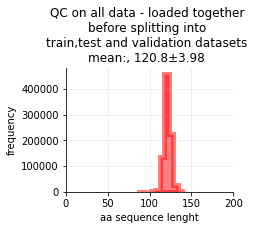

In [5]:
data, data_test = load_and_prepare_the_AAseq_data(
    fname = 'LTSM_AAseq_vlen_data_dct.p',
    path_in=PATH_data_raw,
    path_out=PATH_data_interim,
    load_data_for_ml_dct =dict(
        file_types = organisms, 
        filenames_to_use=filenames_aa_seq_vlen, 
        test_size=0.15, 
        random_state=0, # decides on which samples will be selected to test subset
        verbose=True    
    )
)

### __(b) create train, test and validation subsets, and save them in a dcitinary fomrat used by my pipeline__

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = vlen_data_preprocessing_pipeline(
    parameters = {'Processed_AAseq_Vlen':{"train_size":0.7} }, 
    data = data,
    data_test = data_test,
    random_nr_list = [0],
    path=PATH_data_interim,
    verbose=True
)



.....................................................................
dataset_name:  Processed_AAseq_Vlen
rand_nr: 0
params: {'train_size': 0.7}
.....................................................................

- PART 1 - CREATE TRAIN AND VALIDAITON SUBSETS

-----------------------------------------------
train subset
-----------------------------------------------
. shape: (600996,)
. unique el: (600996,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 120.8±3.98
. examples


0    EVQLVESGGGFAQPGGSLGLSCAASGFVFNTYLRHGVWQGPGNRLV...
1    QVQLVQAGAEVKTPGASVKVSCKGSGYTFNKYGISGVRQAPGQGLE...
Name: aa_seq, dtype: object


-----------------------------------------------
validation subset
-----------------------------------------------
. shape: (257569,)
. unique el: (257569,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 120.81±3.98
. examples


0    QLQLVESGGGVVQPGGSLRLSCVASGFDFRSHDMHWVRQAPGKATE...
1    QVQLLQSGSEVKKPGASVKVSCEISGYTVTALAMHWVRQAPGKGLE...
Name: aa_seq, dtype: object


-----------------------------------------------
test subset
-----------------------------------------------
. shape: (151512,)
. unique el: (151512,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 120.81±3.99
. examples


0    QIQLVQSGPEVRKPGASVKVSCKASGYTFSSYGISWVRQVPGQGLE...
1    QVQLQQPGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...
Name: aa_seq, dtype: object


- PART 2 - second test - it sgodul be only one column in each dataset

train data: X.shape = (600996,), y.shape = (600996,)
valid data: X.shape = (257569,), y.shape = (257569,)
test data: X.shape = (151512,), y.shape = (151512,)
SAVING: Processed_AAseq_Vlen_expanded_v0_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




## PART 1. __SELECT LSTM MODEL TO CREATE LOW LOVEL LSTM MODELS__
---

* in this part, I am using 0.5% - 1% of availbale aa-sequences to quickly evaluate proposed models and data preparation procedures, 
* I am using variable lenght aa-sequences

In [20]:
# file name
tst_scores_valid, y_valid, tst_scores_test, y_test= create_vlen_LSTM_features(
    file_name_in = "Processed_AAseq_Vlen_expanded_v0_dct.p",
    file_name_out = "Vlen_tst_scores_dct.p",
    class_description=organisms,
    path_in = PATH_data_interim,
    path_out = PATH_data_interim,
    verbose = True,
    subset = 0.005,
    subset_all=True,
    lstm_params = dict(embedding_dim=64, hidden_dim=64, device='cpu', gapped=False, fixed_len=False),
    lstm_fit_params = dict(n_epoch=1, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp=None),
    random_nr=0, 
    train_size=0.7
)


PART 1. DATA PREPARATION

Loading: Processed_AAseq_Vlen_expanded_v0_dct.p
train - X:(3005,), y:(3005,)
valid - X:(1288,), y:(1288,)
test - X:(758,), y:(758,)


Epoch 000 (TRN):   0%|| 0/1499 [00:00<?, ?seq/s]

Loading: Processed_AAseq_Vlen_expanded_v0_dct.p
train - X:(3005,), y:(3005,)
valid - X:(1288,), y:(1288,)
test - X:(758,), y:(758,)

PART 2. MODEL TRAINING

Processing: 0, human

. Data Used for LSTM model Training
 - one class train data: (1499,), Labels are OK
 - one class valid data: (679,), Labels are OK

. Traning LTSM Model
 - Model initialized.


          (VLD): 100%|| 679/679 [00:00<00:00, 863.24seq/s, loss=2.816412, acc=0.143861]

 - Done

. Making Predictions



Epoch 000 (TRN):   0%|| 0/1506 [00:00<?, ?seq/s]

Processing: 1, mouse

. Data Used for LSTM model Training
 - one class train data: (1506,), Labels are OK
 - one class valid data: (609,), Labels are OK

. Traning LTSM Model
 - Model initialized.


          (VLD): 100%|| 609/609 [00:00<00:00, 886.71seq/s, loss=2.773826, acc=0.172541]

 - Done

. Making Predictions



100%|| 758/758 [00:00<00:00, 1121.54seq/s]

 - Done
   tst data set shape for validation data is: (1288, 2)
   ie. one column per each class

PART 3. SAVING FILES

SAVING: Vlen_tst_scores_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




#### __Check the results on plots__

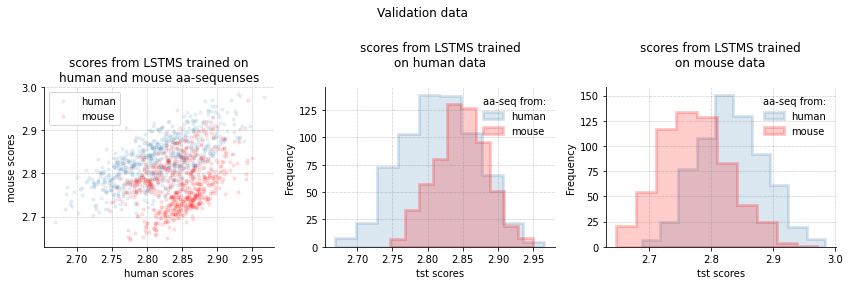

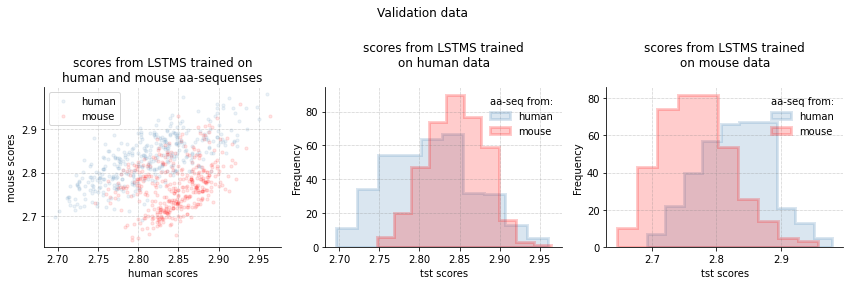

In [21]:
# use LSTMs to create new features
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Validation data")
plot_scatter(axs[0], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained on\nhuman and mouse aa-sequenses")
plot_hist(0,axs[1], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained\non human data\n")
plot_hist(1,axs[2], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained\non mouse data\n")
fig.tight_layout()
fig.subplots_adjust(top=0.7)

# use LSTMs to create new features
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Test data")
plot_scatter(axs[0], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained on\nhuman and mouse aa-sequenses")
plot_hist(0,axs[1], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained\non human data\n")
plot_hist(1,axs[2], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained\non mouse data\n")
fig.tight_layout()
fig.subplots_adjust(top=0.7)


## PART 2. __TRAIN LSTM MODEL WITH ALL AVAILABLE DATA__
---
IMPORTANT COMMENT: 
* I decided to use 10% of the data, because I already got relatively good results with 0.05% of aa-sequences, 
* moreover, it was taking a lot of time, to train lstm model wiht variable lenght aa-sequences,  

In [28]:
# file name
tst_scores_valid, y_valid, tst_scores_test, y_test= create_vlen_LSTM_features(
    file_name_in = "Processed_AAseq_Vlen_expanded_v0_dct.p",
    file_name_out = "ALL_DATA_Vlen_tst_scores_dct.p",
    class_description=organisms,
    path_in = PATH_data_interim,
    path_out = PATH_data_interim,
    verbose = True,
    subset = 0.1,
    subset_all=True,
    lstm_params = dict(embedding_dim=64, hidden_dim=64, device='cpu', gapped=False, fixed_len=False),
    lstm_fit_params = dict(n_epoch=1, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp=None),
    random_nr=0, 
    train_size=0.7
)


PART 1. DATA PREPARATION

Loading: Processed_AAseq_Vlen_expanded_v0_dct.p
train - X:(60100,), y:(60100,)
valid - X:(25757,), y:(25757,)
test - X:(15152,), y:(15152,)
Loading: Processed_AAseq_Vlen_expanded_v0_dct.p
train - X:(60100,), y:(60100,)
valid - X:(25757,), y:(25757,)
test - X:(15152,), y:(15152,)

PART 2. MODEL TRAINING

Processing: 0, human

. Data Used for LSTM model Training
 - one class train data: (30379,), Labels are OK
 - one class valid data: (13045,), Labels are OK

. Traning LTSM Model
 - Model initialized.


          (VLD): 100%|| 13045/13045 [00:14<00:00, 902.64seq/s, loss=1.024162, acc=0.732835]


 - Done

. Making Predictions


100%|| 15152/15152 [00:12<00:00, 1231.52seq/s]


Processing: 1, mouse

. Data Used for LSTM model Training
 - one class train data: (29721,), Labels are OK
 - one class valid data: (12712,), Labels are OK

. Traning LTSM Model
 - Model initialized.


          (VLD): 100%|| 12712/12712 [00:14<00:00, 890.01seq/s, loss=0.617106, acc=0.840332]


 - Done

. Making Predictions


100%|| 15152/15152 [00:12<00:00, 1248.64seq/s]

 - Done
   tst data set shape for validation data is: (25757, 2)
   ie. one column per each class

PART 3. SAVING FILES

SAVING: ALL_DATA_Vlen_tst_scores_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




__evaluate the results on plots__
* TIP: we wish to see well separated points representing human and mouse aa-sequences, shown as blue, and red dots resectively, 

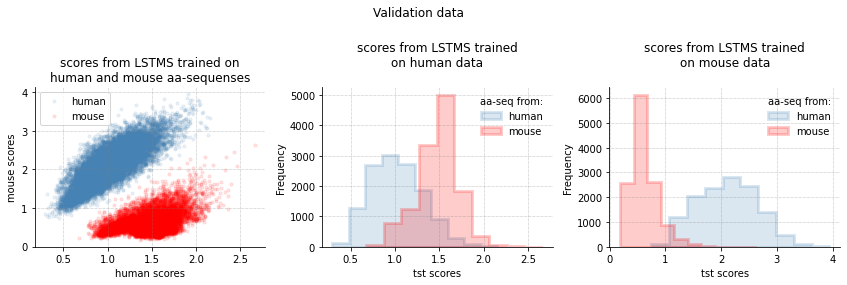

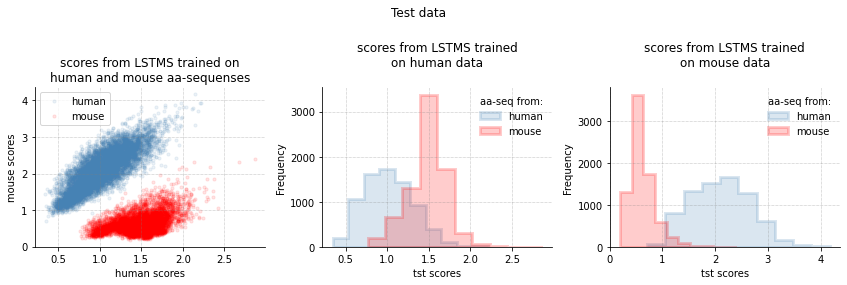

In [29]:
# use LSTMs to create new features
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Validation data")
plot_scatter(axs[0], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained on\nhuman and mouse aa-sequenses")
plot_hist(0,axs[1], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained\non human data\n")
plot_hist(1,axs[2], tst_scores_valid, y_valid, organisms, colors, title="scores from LSTMS trained\non mouse data\n")
fig.tight_layout()
fig.subplots_adjust(top=0.7)

# use LSTMs to create new features
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.suptitle("Test data")
plot_scatter(axs[0], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained on\nhuman and mouse aa-sequenses")
plot_hist(0,axs[1], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained\non human data\n")
plot_hist(1,axs[2], tst_scores_test, y_test, organisms, colors, title="scores from LSTMS trained\non mouse data\n")
fig.tight_layout()
fig.subplots_adjust(top=0.7)

## PART 3. __CREATE HIGH LEVEL CLASSIFIER__
---
* I will use the same pipepline that I used to create sklearn models in Notebook 03, 
* it will automatically generate model performance report for the model wiht the highest ROC-AUC

In [30]:
# model
model = LogisticRegression() # Must be true otherwise it doest allow predict_proba
model_name = "logreg"

# data
path_in = PATH_data_interim
path_out = os.path.join(PATH_results, "lstm_vlen")
dataset_name_list = ["ALL_DATA_Vlen_tst_scores"] # if full name is provided, do not use _dct.p at the end
rand_nr_list = [0] # must be provided to preserve pipeline fucntions, 

# model parameters,
param_grid = ParameterGrid({  
            'C': np.logspace(-4, 4, num=10),
            "penalty":['l2'],
            "class_weight": [None]
        })

# train and evaluate models
stats_valid, stats_test, _, _= train_and_evaluate_models(
    model_name,
    dataset_name_list, 
    rand_nr_list, 
    param_grid, 
    model, 
    path_in=path_in,
    path_out=path_out,
    none_at=None,
    verbose=False,
    b_verbose=True,
    save_predictions=True,
    subset=1,
    subset_all=False,
    shuffle_train=True,
    positive_class=0,
    dataset_full_name=True
)

----------------------------------------------------
model_name: logreg
cond nr: 10
dataset nr: 1
cv nr: 1
----------------------------------------------------

Trainig: ALL_DATA_Vlen_tst_scores  v 0
Loading: ALL_DATA_Vlen_tst_scores_dct.p
train - X:(25757, 2), y:(25757,)
valid - X:(15152, 2), y:(15152,)
test - X:(15152, 2), y:(15152,)

model_id: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/results/lstm_vlen
SAVED:  logreg__model_predictions_list.p
SAVED:  logreg__model_parameters_df.p
SAVED:  logreg__model_statistics_valid_df.p
SAVED:  logreg__model_statistics_test_df.p


In [31]:
# params
model_name_list = ["logreg"] 

# extraxt data
model_statistics_df, model_predictions_valid, model_predictions_test = load_predictions_and_stats(
    os.path.join(PATH_results, "lstm_vlen"), model_name_list, verbose=True)

# reset index
model_statistics_df.reset_index(inplace=True, drop=True)

loading_df 0 logreg__model_statistics_valid_df.p shape_total: (10, 16)
loading_df 0 logreg__model_predictions_list.p shape_total: 10


In [32]:
model_statistics_means = modify_model_statistics_df(model_statistics_df)

In [33]:
top_models = create_group_top_model_list(
    model_statistics_means, 
    order_models_by="ROC_AUC", 
    groupby="model_name", 
    n=5
)
top_models.reset_index(drop=True, inplace=True)
display(top_models.sort_values(by="ROC_AUC", ascending=False))

,model_name,dataset_name,ID,ROC_AUC,Presision,Recall,F1,tr,counts_y,counts_y_hat,model_params
0,logreg,ALL_DATA_Vlen_tst_scores,1,1.0,0.998,0.996,0.997,0.5,"{0: 7502, 1: 7650}","{0: 7514, 1: 7638}","{'C': 0.000774263682681127, 'class_weight': No..."
1,logreg,ALL_DATA_Vlen_tst_scores,2,1.0,1.000,0.998,0.999,0.5,"{0: 7502, 1: 7650}","{0: 7515, 1: 7637}","{'C': 0.005994842503189409, 'class_weight': No..."
2,logreg,ALL_DATA_Vlen_tst_scores,3,1.0,1.000,0.999,0.999,0.5,"{0: 7502, 1: 7650}","{0: 7508, 1: 7644}","{'C': 0.046415888336127774, 'class_weight': No..."
3,logreg,ALL_DATA_Vlen_tst_scores,4,1.0,1.000,1.000,1.000,0.5,"{0: 7502, 1: 7650}","{0: 7503, 1: 7649}","{'C': 0.3593813663804626, 'class_weight': None..."
4,logreg,ALL_DATA_Vlen_tst_scores,5,1.0,1.000,1.000,1.000,0.5,"{0: 7502, 1: 7650}","{0: 7501, 1: 7651}","{'C': 2.782559402207126, 'class_weight': None,..."


---------------------------------------------------------------------------------------------------
TITLE:  Model report for validation dataset
CLASSES:  {0: 'human', 1: 'mouse'}
POSITIVE CLASS:  0
MODEL ID:  1
THRESHOLD:  0.5
...............................................................................................


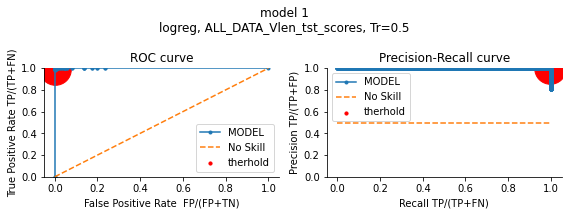

...............................................................................................
MODEL PERFORMANCE


,ID,model_name,dataset_name,Acc_baseline,Acc,ROC_AUC,Recall,Presision,F1,tr,counts_y,counts_y_hat,model_params
0,None,logreg,ALL_DATA_Vlen_tst_scores,0.504884,0.997228,0.999826,0.996471,0.998036,0.997253,0.5,"{0: 7502, 1: 7650}","{0: 7514, 1: 7638}","{'C': 0.000774263682681127, 'class_weight': No..."


...............................................................................................
MODEL PREDICTIONS:  test Data
True labels:                                      {0: 7502, 1: 7650}
Predictions made with standard threshold (tr=0.5): {0: 7514, 1: 7638}
Predictions made with adjusted threshold (tr=0.5): {0: 7638, 1: 7514}
---------------------------------------------------------------------------------------------------




In [34]:
prediciton_test_adjusted = play_with_rocks(
    ID = top_models.ID.iloc[0],
    # ...
    title="Model report for validation dataset",
    subtitle="test Data",
    class_description=dict(zip(list(range(len(organisms))), organisms)),
    # ...
    threshold = 0.5,
    predictions = model_predictions_valid,
    predictions_second_set = None,
    positive_class=0
)